In [ ]:
!pip install vidaug
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
# import keras_metrics as km
# from keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
import math
import vidaug.augmentors as va
from sklearn.utils import shuffle

In [ ]:
data_dir = "/content/drive/MyDrive/video_data"
img_height , img_width = 64, 64
seq_len = 16

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
classes = ["fall_down", "grab", "swallow", "walk","sit","climb",'eat']

In [ ]:
def frames_extraction(video_path):
    frames_list = []
     
    vidcap = cv2.VideoCapture(video_path)
    total_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)

    frames_step = total_frames//seq_len
 
    for j in range(seq_len):
        #here, we set the parameter 1 which is the frame number to the frame (i*frames_step)
        vidcap.set(1,j*frames_step)
        success,image = vidcap.read()  
        #save your image
        if success:
          image = cv2.resize(image, (img_height, img_width))
          frames_list.append(image)
        else:
          print("Defected frame {}".format(video_path))
          break

    return frames_list

In [ ]:
def create_data(input_dir):
    X = []
    Y = []

    sometimes = lambda aug: va.Sometimes(1, aug) # Used to apply augmentor with 100% probability
    
    seq_1 = va.Sequential([ 
        sometimes(va.HorizontalFlip()),
    ])
    seq_2 = va.Sequential([
        sometimes(va.RandomShear(0.2,0.2)),
    ])
    seq_3 = va.Sequential([
        sometimes(va.RandomTranslate(10,10)),
    ])
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)
                X.append(seq_1(frames))
                X.append(seq_2(frames))
                X.append(seq_2(seq_1(frames)))
                X.append(seq_3(frames))
                X.append(seq_3(seq_1(frames)))
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
                Y.append(y)
                Y.append(y)
                Y.append(y)
                Y.append(y)
                Y.append(y)


    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

In [ ]:
X, Y = create_data(data_dir)
X = X/255
print(len(X))
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)

walk
Defected frame /content/drive/MyDrive/video_data/walk/135.mov
Defected frame /content/drive/MyDrive/video_data/walk/143.mov
Defected frame /content/drive/MyDrive/video_data/walk/101.mov
fall_down
Defected frame /content/drive/MyDrive/video_data/fall_down/145.mov
Defected frame /content/drive/MyDrive/video_data/fall_down/143.mov
Defected frame /content/drive/MyDrive/video_data/fall_down/172.mov
Defected frame /content/drive/MyDrive/video_data/fall_down/21.mov
Defected frame /content/drive/MyDrive/video_data/fall_down/26.mov
Defected frame /content/drive/MyDrive/video_data/fall_down/46.mov
Defected frame /content/drive/MyDrive/video_data/fall_down/52.mov
Defected frame /content/drive/MyDrive/video_data/fall_down/57.mov
Defected frame /content/drive/MyDrive/video_data/fall_down/81.mov
swallow
Defected frame /content/drive/MyDrive/video_data/swallow/47.mov
Defected frame /content/drive/MyDrive/video_data/swallow/70.mov
Defected frame /content/drive/MyDrive/video_data/swallow/79_crop (

In [ ]:
# import numpy as np
# np.save('/content/drive/MyDrive/data/save_X_six',X)
# np.save('/content/drive/MyDrive/data/save_Y_six',Y)

In [ ]:
X_=np.load('/content/drive/MyDrive/data/save_X_flip_shear.npy')
Y_=np.load('/content/drive/MyDrive/data/save_Y_flip_shear.npy')
# X_train, y_train = train_test_split(X_, Y_, test_size=0.2, shuffle=True, random_state=36)
# del X_
# del Y_
X_, Y_ = shuffle(X_,Y_, random_state = 36)

In [ ]:
model = Sequential()

model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3),strides = (2,2), return_sequences = True, input_shape = (seq_len, img_height, img_width, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('tanh'))
model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3),strides = (2,2), return_sequences = True))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('tanh'))
model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3),strides = (2,2), return_sequences = True))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('tanh'))
model.add(ConvLSTM2D(filters = 128, kernel_size = (3, 3),strides = (2,2), return_sequences = False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('tanh'))


model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(7, activation = "softmax"))
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 16, 31, 31, 32)    40448     
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 31, 31, 32)    128       
_________________________________________________________________
activation (Activation)      (None, 16, 31, 31, 32)    0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 16, 15, 15, 32)    73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 15, 15, 32)    128       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 15, 15, 32)    0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 16, 7, 7, 64)      2

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/40
45/45 [==============================] - 894s 20s/step - loss: 1.8312 - accuracy: 0.3029 - val_loss: 1.9697 - val_accuracy: 0.1634

Epoch 00001: val_loss improved from inf to 1.96970, saving model to /content/drive/MyDrive/model/checkpoint-epoch-40-batch-128-4aug-4batch.h5
Epoch 2/40
45/45 [==============================] - 905s 20s/step - loss: 1.3720 - accuracy: 0.4725 - val_loss: 2.7369 - val_accuracy: 0.1634

Epoch 00002: val_loss did not improve from 1.96970
Epoch 3/40
45/45 [==============================] - 890s 20s/step - loss: 1.0405 - accuracy: 0.6087 - val_loss: 3.5453 - val_accuracy: 0.1634

Epoch 00003: val_loss did not improve from 1.96970
Epoch 4/40
45/45 [==============================] - 904s 20s/step - loss: 0.8082 - accuracy: 0.6989 - val_loss: 3.5118 - val_accuracy: 0.1648

Epoch 00004: val_loss did not improve from 1.96970
Epoch 5/40
45/45 [==============================] - 882s 20s/step - loss: 0.5977 - accuracy: 0.7901 - val_loss: 5.1007 - val_accuracy

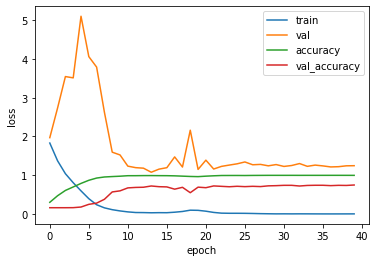

In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

EPOCH = 40
BATCH_SIZE = 128

# earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# callbacks = tf.keras.callbacks.LearningRateScheduler(schedular)

filename = '/content/drive/MyDrive/model/checkpoint-epoch-{}-batch-{}-4aug-4batch.h5'.format(EPOCH, BATCH_SIZE)
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x = X_, y = Y_, epochs=EPOCH, batch_size=BATCH_SIZE, shuffle=True, validation_split=0.2, callbacks=[checkpoint])

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val','accuracy','val_accuracy'])
plt.show()


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test) 
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
 
print(classification_report(y_test, y_pred))

print('accuracy score : {}'.format(accuracy_score(y_pred, y_test)))
